# Cell Types Database

This notebook will help us investigate specific features in the electrophysiology dataset from the Allen Brain Atlas.

- - - 
##### Technical notes

This notebook demonstrates most of the features of the AllenSDK that help manipulate data in the Cell Types Database.  The main entry point will be through the `CellTypesCache` class. `CellTypesCache` is responsible for downloading Cell Types Database data to a standard directory structure on your hard drive.  If you use this class, you will not have to keep track of where your data lives, other than a root directory.

This file modified from <a href='cell_types.ipynb'>this</a> notebook.

- - -

## Step 1: Importing Allen data
First, we need to get some of the raw data. We can do this by communicating with the Allen SDK to grab a "Neuroscience Without Borders" (NWB) file that will contain the data for one cell.

Find the cell specimen ID for the first cell you looked at in the first portion of the lab (hint: it's in the URL), and enter this after cell_specimen_id.

This might take a minute or two.

In [3]:
from allensdk.core.cell_types_cache import CellTypesCache
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
# this saves the NWB file to 'cell_types/specimen_#/ephys.nwb'

# change your cell_id below
cell_id = 474626527
data_set = ctc.get_ephys_data(cell_id)
print('Data retrieved')

Data retrieved


Now, let's import (and rename) a few packages that we need to plot our data.

In [2]:
 #The following line allows us to show plots in the jupyter notebook
%matplotlib inline

#import a few packages to plot
import numpy as np
import matplotlib.pyplot as plt

print('Packages imported')

Packages imported


Our NWB file has some built in methods to enable us to pull out a sweep. Choose your favorite sweep below. (Hint, you can go back to the website to see what the sweep numbers are.)

In [7]:
sweep_number = 27
sweep_data = data_set.get_sweep(sweep_number) 
print('Sweep obtained')

Sweep obtained


## Step 2: Plotting electrophysiology data
Now that you've pulled down some data, chosen a cell, and chosen a sweep number, let's plot that data.

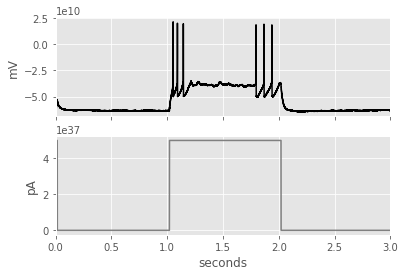

In [11]:
index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # this converts the value to pA
v *= 1e3 # this converts the value to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = (np.arange(0, len(v)) * (1.0 / sampling_rate))

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)

# axes 0 is our first plot, of the recorded voltage data
axes[0].plot(t, v, color='black')
axes[0].set_ylabel("mV")
axes[0].set_xlim(0,3)

#axes 1 is our second plot, of the stimulus trace
axes[1].plot(t, i, color='gray')
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")

plt.show()

This plot probably looks different from the plot on the website, why?

<b>Hint:</b> There is a line that has been commented out above. Uncomment the line to change the scaling of the x-axis in order to zoom in on the period where the current was applied. If necessary, change the second value in set_xlim to change the extent of the x axis. Re-run the cell to re-plot the data.

## Step 3 Plotting the morphology of the cell
The Cell Types Database also contains 3D reconstructions of neuronal morphologies. Here, we'll plot the reconstruction of our cell's morphology. It may take a little time to run this cell.

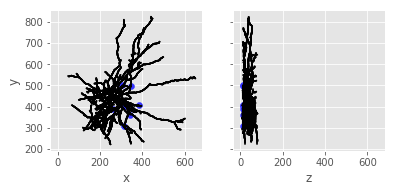

In [12]:
import pprint

# download and open SWC and marker files
morphology = ctc.get_reconstruction(cell_id) 
markers = ctc.get_reconstruction_markers(cell_id) 

# plot
from allensdk.core.swc import Marker
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

# cut dendrite markers
dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]
axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]
axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')
axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
plt.show()

## Step 4: Filtering Cells via Metadata

Cell records in the Cell Types Database come with a large amount of metadata. We can use "CellTypesCache.get_cells" to specify which cells we want.

First, let's get an idea of all of the data that exists for us to analyze.

In [13]:
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS

# download all cells
cells = ctc.get_cells()
print("Total cells: %d" % len(cells))

# mouse cells
cells = ctc.get_cells(species=[CellTypesApi.MOUSE])
print("Mouse cells: %d" % len(cells))

# human cells
cells = ctc.get_cells(species=[CellTypesApi.HUMAN])
print("Human cells: %d" % len(cells))

Total cells: 2333
Mouse cells: 1920
Human cells: 413


The Cell Types Database contains a set of features that have already been computed, which could serve as good starting points for analysis. We can query the database to get these features. Let's first see which features are available.

<b>Note</b> you may get an error that says 'from_csv is deprecated' while running this, but it won't disrupt the script. You can ignore it.

In [14]:
import pandas as pd

# download all electrophysiology features for all cells
ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)

print("Ephys features available for %d cells" % len(ef_df))

# look at the features available for our cell
cell_ephys_features = ef_df[ef_df['specimen_id']== cell_id]
cell_ephys_features

/datasets/home/61/361/ajuavine/.local/lib/python3.6/site-packages/allensdk/api/cache.py:386: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  'reader': lambda f: pd.DataFrame.from_csv(f).to_dict('records')


Ephys features available for 2333 cells


,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,has_burst,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
1542,34.796538,15.709375,0.575532,1.10479,2.759537,1.02487,-50.8125,-48.989586,-52.523439,False,...,2.767942,1.540014,-51.500004,-50.885419,-63.67969,2.329841,2.036241,2.32015,-100.5,-62.611252


That's how to get all the ephys features for a given specimen - what if we want a particular feature for all cells?

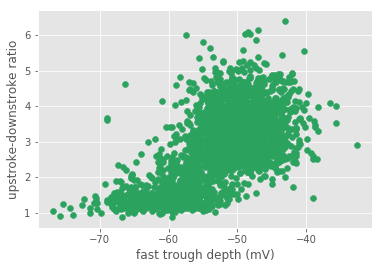

In [15]:
plt.figure()
plt.scatter(ef_df['fast_trough_v_long_square'], 
            ef_df['upstroke_downstroke_ratio_long_square'], color='#2ca25f')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")
plt.show()

Let's use numpy to fit a regression line to these data and plot it.

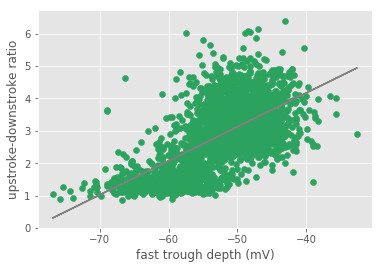

In [16]:
A = np.vstack([ef_df['fast_trough_v_long_square'], 
               np.ones_like(ef_df['upstroke_downstroke_ratio_long_square'])]).T
m, c = np.linalg.lstsq(A, ef_df['upstroke_downstroke_ratio_long_square'])[0]
#print("m", m, "c", c)

plt.figure()
plt.scatter(ef_df['fast_trough_v_long_square'], 
            ef_df['upstroke_downstroke_ratio_long_square'], 
            color='#2ca25f')
plt.plot(ef_df['fast_trough_v_long_square'],
         m * ef_df['fast_trough_v_long_square'] + c, c='gray')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")
plt.show()

It looks like there may be roughly two clusters in the data above. Maybe they relate to whether the cells are presumably excitatory (spiny) cells or inhibitory (aspiny) cells. Let's query the API and split up the two sets to see.

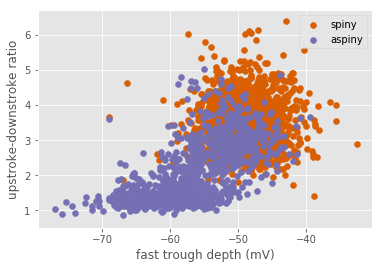

In [17]:
cells = ctc.get_cells()

# we want to add dendrite type as a column to the ephys. features dataframe
# first build an index on cell specimen ID, then create array of dendrite types
cell_index = { c['id']: c for c in cells }
dendrite_types = [ cell_index[cid]['dendrite_type'] for cid in ef_df['specimen_id'] ]

# now add the new column
ef_df['dendrite_type'] = pd.Series(dendrite_types, index=ef_df.index)

fig = plt.figure()

for d_type, color in [ ["spiny", "#d95f02"], ["aspiny", "#7570b3"] ]:
    df = ef_df[ef_df['dendrite_type'] == d_type]
    plt.scatter(df['fast_trough_v_long_square'], 
                df['upstroke_downstroke_ratio_long_square'], 
                color=color, label=d_type)

    plt.ylabel("upstroke-downstroke ratio")
    plt.xlabel("fast trough depth (mV)")
    plt.legend(loc='best')
    
plt.show()

## Step 5: Comparing human to mouse cells
Now, we can make a similar plot, but subselected for human and mouse cells.

In [18]:
# make a dataframe out of ephys features
ephys_features_df = pd.DataFrame.from_records(ephys_features)
ephys_features_df.head(1)

# grab mouse data and merge with dataframe
mouse_cells = ctc.get_cells(species=[CellTypesApi.MOUSE])
mouse_df = pd.DataFrame(mouse_cells)
mouse_ephys_df = pd.merge(mouse_df,ephys_features_df,left_on='id',right_on='specimen_id',how='left')

# grab human data and merge with dataframe
human_cells = ctc.get_cells(species=[CellTypesApi.HUMAN])
human_df = pd.DataFrame(human_cells)
human_ephys_df = pd.merge(human_df,ephys_features_df,left_on='id',right_on='specimen_id',how='left')


Let's look at the first ten rows of our mouse and human datasets here. Scroll to the right within the table to see the parameters for the cell.

In [19]:
mouse_ephys_df[1:10]

,apical,cell_soma_location,dendrite_type,disease_state,donor_id,id_x,name,normalized_depth,reconstruction_type,reporter_status,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
1,NA,"[7872.53138541818, 993.212032389272, 3127.1530...",aspiny,,319194354,469801138,Pvalb-IRES-Cre;Ai14-170927.05.02.01,0.469578,None,positive,...,11.763808,1.290815,-55.875000,-52.515627,-69.109379,1.162618,1.197155,1.369171,-80.156250,-72.042976
2,NA,"[9400.0, 1520.74232706376, 2188.13845194139]",aspiny,,605622695,605889373,Vipr2-IRES2-Cre;Slc32a1-T2A-FlpO;Ai65-337419.0...,NaN,None,positive,...,8.432940,1.315510,-48.187500,-54.364586,-72.640628,3.379321,4.108774,2.680139,-83.593758,-72.712036
3,intact,"[8881.0, 953.839501299405, 7768.22695782726]",spiny,,485250100,485909730,Cux2-CreERT2;Ai14-205530.03.02.01,0.478344,dendrite-only,positive,...,2.888133,1.520193,-54.031254,-57.385419,-77.750005,3.042933,3.517684,3.274181,-101.000000,-76.928391
4,intact,"[8125.0, 904.841803028986, 7819.69986630448]",spiny,,322489588,323865917,Scnn1a-Tg3-Cre;Ai14-172530.06.01.01,0.608590,dendrite-only,positive,...,3.467847,1.317042,-57.281254,-56.895833,-70.218751,2.974194,3.156117,2.946463,-88.406250,-69.402855
5,NA,"[8294.0, 828.8846152563, 3320.65602051487]",aspiny,,581538789,583836069,Htr3a-Cre_NO152;Ai14-314135.05.02.02,NaN,None,positive,...,NaN,1.380780,-48.593754,NaN,-63.257814,2.132316,NaN,2.185564,-87.656250,-62.055580
6,intact,"[9022.31795341815, 1034.01756171273, 3750.0960...",spiny,,503871551,504615116,Rorb-IRES2-Cre-D;Ai14-234241.04.02.01,0.684800,None,positive,...,3.430607,1.105444,-57.281254,-56.406253,-70.537502,4.059995,4.121745,4.017244,-87.093758,-69.362984
7,truncated,"[9226.81555310021, 2289.94455323552, 9055.3277...",spiny,,557265267,558076716,Ctgf-2A-dgCre;Ai14(IVSCC)-280859.04.01.01,NaN,None,positive,...,5.184920,1.450500,-54.500004,-54.833336,-70.614586,5.164409,5.124497,4.561945,-84.937508,-70.497147
8,intact,"[8711.26681152, 1417.44904628, 8895.04077315]",spiny,,475849748,476135066,Scnn1a-Tg3-Cre;Ai14-187849.06.01.01,0.419116,dendrite-only,positive,...,5.837250,1.416055,-54.281254,-55.656254,-75.062500,3.386317,3.171764,3.857029,-87.000008,-75.066132
9,intact,"[9918.74841340251, 2116.91601361369, 2202.7718...",spiny,,502081962,502614426,Rorb-IRES2-Cre-D;Ai14-230822.04.02.01,0.411748,dendrite-only,positive,...,3.895613,1.669068,-55.000004,-53.500001,-71.262505,3.940221,3.511122,3.560241,-94.000008,-70.157845


In [20]:
human_ephys_df[1:10]

,apical,cell_soma_location,dendrite_type,disease_state,donor_id,id_x,name,normalized_depth,reconstruction_type,reporter_status,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
1,NA,"[69.0, 254.0, 96.0]",aspiny,epilepsy,528574320,528642047,H16.06.009.01.02.06.05,NaN,None,None,...,NaN,1.051160,-67.468758,NaN,-70.875002,1.891881,NaN,1.989616,-101.000000,-69.209610
2,truncated,"[322.0, 255.0, 92.0]",spiny,epilepsy,536912860,537256313,H16.03.006.01.05.02,NaN,None,None,...,5.694547,1.389900,-52.125004,-51.520836,-72.900002,3.121182,3.464528,3.054681,-87.531250,-72.628105
3,truncated,"[79.0, 273.0, 91.0]",spiny,epilepsy,518641172,519832676,H16.03.001.01.09.01,0.290951,full,None,...,9.962780,1.211020,-53.875004,-52.416668,-73.693753,4.574865,3.817988,4.980603,-84.218758,-72.547661
4,intact,"[110.0, 122.0, 240.0]",spiny,tumor,569008241,569095789,H17.06.004.11.05.04,0.056400,full,None,...,5.483953,1.225900,-51.406254,-59.552087,-81.875008,2.199872,2.220031,2.235442,-95.843758,-81.065971
5,NA,"[274.0, 331.0, 228.0]",aspiny,tumor,576060516,576095991,H17.06.007.11.08.01,0.673428,full,None,...,3.245000,1.053000,-59.156254,-61.437502,-67.625004,2.520616,2.586455,2.219604,-81.406250,-64.442192
6,intact,"[312.0, 280.0, 89.0]",spiny,epilepsy,545510854,545608578,H16.03.010.13.06.01,NaN,None,None,...,22.069340,1.112633,-54.343754,-54.968751,-75.156258,3.675430,3.665890,3.586321,-78.500000,-74.496262
7,truncated,"[79.0, 273.0, 86.0]",spiny,epilepsy,561414332,561467633,H16.06.013.12.08.05,NaN,None,None,...,6.479140,1.174147,-60.312504,-57.989586,-71.020838,4.149998,3.667004,3.929834,-78.312500,-69.626610
8,intact,"[70.0, 260.0, 108.0]",spiny,epilepsy,528574320,528706755,H16.06.009.01.01.15.01,0.134667,dendrite-only,None,...,10.173433,1.670800,-47.062500,-52.302085,-72.343750,2.806181,3.007196,2.592416,-82.593758,-72.490135
9,NA,"[127.0, 354.0, 219.0]",aspiny,tumor,518229880,531520637,H16.06.007.01.05.03,0.388676,full,None,...,13.983713,1.427020,-62.125000,-62.718751,-77.043750,1.315267,1.307436,1.375686,-85.250008,-76.195251


Let's start by plotting the resting membrane potential for all of our human cells vs all of our mouse cells.

Documentation for plotting: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.html

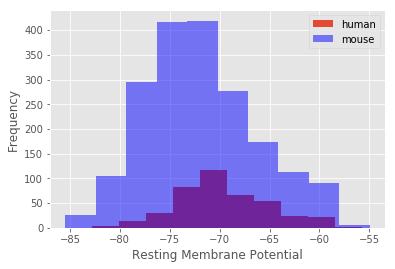

In [22]:
fig = plt.figure()

# below it is set to plot input resistance ("ri"). this is where you can change what is being plotted.
axes = human_ephys_df['vrest'].plot(kind="hist")
axes = mouse_ephys_df['vrest'].plot(kind="hist",fc=(0, 0, 1, 0.5))

# this is where you should change the label:
axes.set_xlabel('Resting Membrane Potential')
axes.legend(['human','mouse'])
plt.show()

Choose a different parameter to compare between human and mouse cells, and rerun the plot above. Use the tables above to get the exact name of the parameter, and change the x label axis so that we know what you're plotting.

## Morphology Features

The Cell Types Database contains a set of precomputed morphological features for cells that have reconstructions.  You can access morphology features by themselves, or combined with the electrophysiology features.

In [ ]:
import pandas as pd

# download all morphology features for cells with reconstructions
morphology_features = ctc.get_morphology_features()

# or download both morphology and ephys features
all_features = ctc.get_all_features(require_reconstruction=True)

# convert to a pandas DataFrame
all_features = pd.DataFrame(all_features)
print("All features available for %d cells" % len(all_features))

all_features.head()